In [7]:
# import sys  
# from pathlib import Path
# sys.path[0] = str(Path(sys.path[0]).parent)
# print(sys.path)

In [3]:
# Imports

from loguru import logger
from collections import defaultdict
from src.outlier_detection_methods import FewShotDetector, NaiveAggregator, local_knn
from src.utils.utils import (
    set_random_seed, load_model, merge_from_dict
)
from src.augmentations import __dict__ as AUGMENTATIONS
from typing import Dict
from types import SimpleNamespace
import yaml
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from src.utils.data_fetchers import get_task_loader, get_test_features
from sklearn.metrics import roc_auc_score, roc_curve, auc
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import pyod

In [4]:
# Variables

dataset = "mini_imagenet"
image_size = 84
n_way = 5
n_shot = 1
n_query = 10
n_tasks = 500
backbone = 'resnet12'
training = 'feat'

In [34]:
logger.info("Building model...")
weights = Path('data') / 'models' / f'{backbone}_{dataset}_{training}.pth'
feature_extractor = load_model(backbone=backbone,
                               weights=weights,
                               dataset_name=dataset,
                               device='cuda')
feature_extractor.eval()

logger.info("Loading data...")
data_loader = get_task_loader(dataset,
                              image_size,
                              n_way,
                              n_shot,
                              n_query,
                              n_tasks,
                              split="test",
                              n_workers=4)

logger.info("Loading mean/std from base set ...")

layers = [f'{i}_{j}' for j in range(4) for i in range(3, 5)]
train_features = {}
std_train_features = {}
for layer in tqdm(layers):
    _, _, train_features[layer], std_train_features[layer] = get_test_features(
        backbone, dataset, training, layer)

2022-02-07 11:56:28.147 | INFO     | __main__:<module>:1 - Building model...
2022-02-07 11:56:28.148 | INFO     | src.utils.utils:load_model:110 - Fetching data...
100%|██████████| 38400/38400 [00:00<00:00, 2788988.10it/s]
2022-02-07 11:56:48.916 | INFO     | src.utils.utils:load_model:113 - Building model...
2022-02-07 11:56:49.103 | INFO     | __main__:<module>:9 - Loading data...


Loaded weights from data/models/resnet12_mini_imagenet_feat.pth
Missing keys []
Unexpected keys []


100%|██████████| 12000/12000 [00:00<00:00, 2572929.56it/s]
2022-02-07 11:56:49.462 | INFO     | __main__:<module>:19 - Loading mean/std from base set ...
100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


In [75]:
def plot_grid(images: Tensor):
    fig = plt.figure(figsize=(15, 75))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )
    std = torch.Tensor([0.229, 0.224, 0.225]).to(images.device).view(3, 1, 1)
    mean = torch.Tensor([0.485, 0.456, 0.406]).to(images.device).view(3, 1, 1)
    shifted = images * std + mean
    for ax, im in zip(grid, shifted):
        # Iterating over the grid returns the Axes.
        ax.imshow(im.permute(1, 2, 0))
        
def gram(t1: Tensor, t2: Tensor):
    """
    t1: [N1, d]
    t2: [N2, d]
    returns: [N1, N2]
    """
    assert len(t1.size()) == 2, "Only accepts pooled images"
#     t1 = F.normalize(t1, dim=1)
#     t2 = F.normalize(t2, dim=1)
    return torch.cdist(t1, t2) ** 2

In [56]:
def transform(feat: Tensor, layer: str, center: bool):
    if center:
        feat = feat - train_features[layer].cuda()
    feat = F.normalize(feat, dim=1)
    return feat

def convolve_feature_maps(support: Tensor, query: Tensor, kernel_size: int):
    """
    map_1: [Ns, c, h, w]
    map_2: [Nq, c, h, w]
    returns [Nq, Ns, L, h', w']
    """
    kh = kw = kernel_size
    N, c, h, w = support.size()
    fold_params = dict(kernel_size=(kh, kw), stride=1)
    unfold = nn.Unfold(**fold_params)
    unfold_map1 = unfold(support) # [N, c*kw*kh, L]
    kernels = unfold_map1.view(N, c, kh, kh, -1).permute(0, 4, 1, 2, 3) # [Ns, L, c, kw, kh]
    conv_results = []
    for kernel in kernels:
        conv_results.append(F.conv2d(query, kernel)) # [Nq, L, h', w']
    return torch.stack(conv_results, 1) # [Nq, Ns, L, h', w']
    

### Trying this convolution idea

In [98]:
layer = "4_0"
center = True
kh = 3
id_scores = []
ood_scores = []
rocauc = []
set_random_seed(2020)
with torch.no_grad():
    for i, (support, support_labels, query, query_labels, _) in tqdm(enumerate(data_loader)):        
        feat_s = feature_extractor(support.cuda(), layer)[layer]
        feat_q = feature_extractor(query.cuda(), layer)[layer]
        feat_s = transform(feat_s, layer, center)
        feat_q = transform(feat_q, layer, center)
        convolved_res = convolve_feature_maps(feat_s, feat_q, kh) # [Nq, Ns, L, h', w']
        if i == 0:
            logger.info(convolved_res.size())
        
        # 1 - naive solutions
#         similarity_scores = convolved_res.view(feat_q.size(0), -1).max(1).values
#         similarity_scores = convolved_res.view(feat_q.size(0), -1).mean(1)
#         similarity_scores = convolved_res.view(feat_q.size(0), -1).topk(k=30, dim=1).values.mean(1)

        # 2 - "Improved" solution
#         Nq, Ns, L, h, w = convolved_res.size()        
#         convolved_res = convolved_res.flatten(start_dim=3) # [Nq, Ns, L, h' * w']
#         convolved_res = convolved_res.topk(3, dim=-1).values.mean(-1) # [Nq, Ns, L]
#         convolved_res = convolved_res.topk(3, dim=-1).values.mean(-1) # [Nq, Ns]
#         print(convolved_res.size())
#         similarity_scores = convolved_res.max(-1).values

        # 2 - Trying to weight features
        similarity_scores = convolved_res.mean((-2, -1)).topk(k=3, dim=2).values.mean(2).max(1).values # [Nq, Ns, L]

        id_scores.append(similarity_scores[:n_way * n_query])
        ood_scores.append(similarity_scores[n_way * n_query:])
        auc = roc_auc_score(np.concatenate([np.zeros(n_way * n_query), np.ones(n_way * n_query)]),
                            -similarity_scores.cpu().numpy()
                            )
        rocauc.append(auc)
        if i >= 500:
            break

0it [00:00, ?it/s]2022-02-06 10:05:43.801 | INFO     | __main__:<module>:16 - torch.Size([10, 5, 64, 8, 8])
500it [00:39, 12.52it/s]


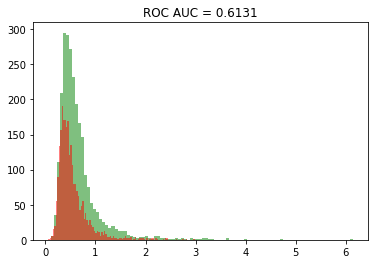

In [99]:
_ = plt.hist(torch.cat(id_scores).cpu().numpy(), bins=100, facecolor='g', alpha=0.5)
_ = plt.hist(torch.cat(ood_scores).cpu().numpy(), bins=100, facecolor='r', alpha=0.5)
_ = plt.title(f"ROC AUC = {np.round(np.mean(rocauc), 4)}")

# Is the last layer always the best ?

In [33]:
layers = ["4_0", "4_1", "4_2", "4_3"]
id_scores = []
ood_scores = []
rocauc = []
best_layers = []

detector = pyod.models.knn.KNN(n_neighbors=2, method='mean')
set_random_seed(0)

with torch.no_grad():
    for i, (support, support_labels, query, query_labels, true_class_ids) in tqdm(enumerate(data_loader)):
        all_feat_s = feature_extractor(support.cuda(), layers)
        all_feat_q = feature_extractor(query.cuda(), layers)
        
        layer_aucs = []
        sims = []
        
        for layer in layers:
            feat_s = all_feat_s[layer]
            feat_q = all_feat_q[layer]
            
            feat_s -= train_features[layer].cuda()
            feat_q -= train_features[layer].cuda()
            
            feat_s = feat_s.mean((-2, -1))
            feat_q = feat_q.mean((-2, -1))
            

            feat_s = F.normalize(feat_s, dim=1, p=2) # [Ns, c]
            feat_q = F.normalize(feat_q, dim=1, p=2) # [Nq, c]
            
            
            
            detector.fit(feat_s.cpu())
            similarity_scores = - detector.decision_function(feat_q.cpu())
            
            
        
#             similarity_scores = - torch.cdist(feat_s, feat_q) # [Ns, Nq]
#             similarity_scores = similarity_scores.topk(k=kh, dim=0).values.mean(0)
            sims.append(similarity_scores)
            gt = np.concatenate([np.zeros(n_way * n_query), np.ones(n_way * n_query)])
            scores = -similarity_scores
#             auc = roc_auc_score(gt, scores)
#             layer_aucs.append(auc)
            fp_rate, tp_rate, thresholds = roc_curve(gt, scores)
            layer_aucs.append(auc(fp_rate, tp_rate))

        sims = np.stack(sims, 0)
        best_layer = np.argmax(layer_aucs)
        id_scores.append(sims[best_layer, :n_way * n_query])
        ood_scores.append(sims[best_layer, n_way * n_query:])
        best_layers.append(best_layer)
        rocauc.append(layer_aucs[best_layer])

2022-02-07 11:55:44.080 | INFO     | __main__:<module>:10 - Loading data...
100%|██████████| 12000/12000 [00:00<00:00, 2744963.35it/s]
0it [00:00, ?it/s]


TypeError: 'numpy.float64' object is not callable

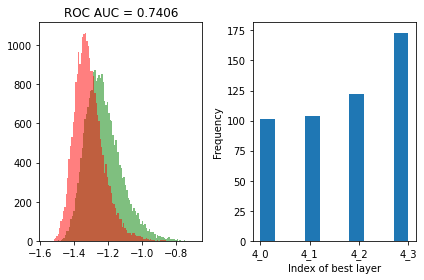

In [14]:
plt.figure(1)
plt.subplot(121)
_ = plt.hist(np.concatenate(id_scores), bins=100, facecolor='g', alpha=0.5)
_ = plt.hist(np.concatenate(ood_scores), bins=100, facecolor='r', alpha=0.5)
_ = plt.title(f"ROC AUC = {np.round(np.mean(rocauc), 4)}")
plt.subplot(122)
_ = plt.hist(best_layers)
plt.xlabel('Index of best layer')
plt.xticks(range(len(layers)), layers)
plt.ylabel("Frequency")
plt.tight_layout()

# A naive idea : combining the scores of all layers ?

In [39]:
layers = ["4_0", "4_1", "4_2", "4_3"]
center = True
id_scores = []
ood_scores = []
kh = 2
rocauc = []
set_random_seed(0)
with torch.no_grad():
    for i, (support, support_labels, query, query_labels, _) in tqdm(enumerate(data_loader)):        
        all_feat_s = feature_extractor(support.cuda(), layers)
        all_feat_q = feature_extractor(query.cuda(), layers)
    
        sims = []
        
        for layer in layers:
            feat_s = all_feat_s[layer].mean((-2, -1))
            feat_q = all_feat_q[layer].mean((-2, -1))
            
            feat_s -= train_features[layer].cuda().mean((-2, -1))
            feat_q -= train_features[layer].cuda().mean((-2, -1))        

            feat_s = F.normalize(feat_s, dim=1) # [Ns, c]
            feat_q = F.normalize(feat_q, dim=1) # [Nq, c]
        
            similarity_scores = - torch.cdist(feat_s, feat_q)  # [Ns, Nq]
            similarity_scores = similarity_scores.topk(k=kh, dim=0).values.mean(0)
            
#             similarity_scores = (similarity_scores - similarity_scores.min()) / (similarity_scores.max() - similarity_scores.min())
            sims.append(similarity_scores)

        sims = torch.stack(sims, 0).mean(0)
        auc = roc_auc_score(np.concatenate([np.zeros(n_way * n_query), np.ones(n_way * n_query)]),
                    -sims.cpu().numpy()
                    )
        id_scores.append(sims[:n_way * n_query])
        ood_scores.append(sims[n_way * n_query:])
        rocauc.append(auc)
        if i >= 1000:
            break

500it [00:56,  8.78it/s]


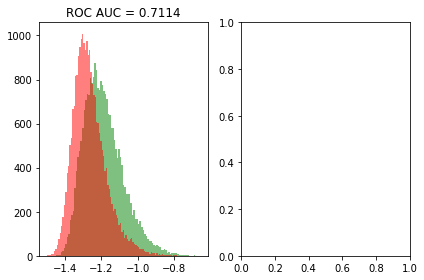

In [38]:
plt.figure(1)
plt.subplot(121)
_ = plt.hist(torch.cat(id_scores).cpu().numpy(), bins=100, facecolor='g', alpha=0.5)
_ = plt.hist(torch.cat(ood_scores).cpu().numpy(), bins=100, facecolor='r', alpha=0.5)
_ = plt.title(f"ROC AUC = {np.round(np.mean(rocauc), 4)}")
plt.subplot(122)
plt.tight_layout()

### Checking map dimensions

In [20]:
# Just checking maps dimensions
layers = [f'{i}_0' for i in range(1, 5)]
with torch.no_grad():
    for i, (support, support_labels, query, query_labels, _) in tqdm(enumerate(data_loader)):        
        feat_s = feature_extractor(support.cuda(), layers)
        feat_q = feature_extractor(support.cuda(), layers)
        break
        
for layer in feat_s:
    logger.info(f"Layer {layer} of shape: {feat_s[layer].size()}")

0it [00:00, ?it/s]
2022-02-05 09:21:33.136 | INFO     | __main__:<module>:10 - Layer 1_0 of shape: torch.Size([5, 64, 84, 84])
2022-02-05 09:21:33.136 | INFO     | __main__:<module>:10 - Layer 2_0 of shape: torch.Size([5, 160, 42, 42])
2022-02-05 09:21:33.137 | INFO     | __main__:<module>:10 - Layer 3_0 of shape: torch.Size([5, 320, 21, 21])
2022-02-05 09:21:33.139 | INFO     | __main__:<module>:10 - Layer 4_0 of shape: torch.Size([5, 640, 10, 10])
